In [492]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import datetime as dt
from operator import attrgetter

plt.style.use('ggplot')

In [493]:
df = pd.read_csv('supermarket.csv')
df.tail(3)

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,...,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
578079,200637,20061109,5,16,1,4.47,PRD0900396,CL00229,DEP00081,G00027,...,UM,NaN,994103100229855,L,MM,Full Shop,Mixed,STORE00001,LS,E02
578080,200717,20070624,1,10,1,4.92,PRD0903065,CL00229,DEP00081,G00027,...,UM,YF,994106300437841,L,MM,Full Shop,Mixed,STORE00001,LS,E02
578081,200744,20071229,7,14,1,9.27,PRD0901923,CL00229,DEP00081,G00027,...,UM,NaN,994109000359411,L,MM,Top Up,Mixed,STORE00001,LS,E02


In [494]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578082 entries, 0 to 578081
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SHOP_WEEK                 578082 non-null  int64  
 1   SHOP_DATE                 578082 non-null  int64  
 2   SHOP_WEEKDAY              578082 non-null  int64  
 3   SHOP_HOUR                 578082 non-null  int64  
 4   QUANTITY                  578082 non-null  int64  
 5   SPEND                     578082 non-null  float64
 6   PROD_CODE                 578082 non-null  object 
 7   PROD_CODE_10              578082 non-null  object 
 8   PROD_CODE_20              578082 non-null  object 
 9   PROD_CODE_30              578082 non-null  object 
 10  PROD_CODE_40              578082 non-null  object 
 11  CUST_CODE                 492494 non-null  object 
 12  CUST_PRICE_SENSITIVITY    492494 non-null  object 
 13  CUST_LIFESTAGE            433142 non-null  o

In [495]:
# Found missing values on CUST_CODE, CUST_PRICE_SENSITIVITY, CUST_LIFESTAGE columns
df.isna().sum()

SHOP_WEEK                        0
SHOP_DATE                        0
SHOP_WEEKDAY                     0
SHOP_HOUR                        0
QUANTITY                         0
SPEND                            0
PROD_CODE                        0
PROD_CODE_10                     0
PROD_CODE_20                     0
PROD_CODE_30                     0
PROD_CODE_40                     0
CUST_CODE                    85588
CUST_PRICE_SENSITIVITY       85588
CUST_LIFESTAGE              144940
BASKET_ID                        0
BASKET_SIZE                      0
BASKET_PRICE_SENSITIVITY         0
BASKET_TYPE                      0
BASKET_DOMINANT_MISSION          0
STORE_CODE                       0
STORE_FORMAT                     0
STORE_REGION                     0
dtype: int64

In [496]:
# Clean missing values
df.dropna(subset=['CUST_CODE'], inplace=True)
df['CUST_LIFESTAGE'] = df['CUST_LIFESTAGE'].fillna('XX')
df.isna().sum()

SHOP_WEEK                   0
SHOP_DATE                   0
SHOP_WEEKDAY                0
SHOP_HOUR                   0
QUANTITY                    0
SPEND                       0
PROD_CODE                   0
PROD_CODE_10                0
PROD_CODE_20                0
PROD_CODE_30                0
PROD_CODE_40                0
CUST_CODE                   0
CUST_PRICE_SENSITIVITY      0
CUST_LIFESTAGE              0
BASKET_ID                   0
BASKET_SIZE                 0
BASKET_PRICE_SENSITIVITY    0
BASKET_TYPE                 0
BASKET_DOMINANT_MISSION     0
STORE_CODE                  0
STORE_FORMAT                0
STORE_REGION                0
dtype: int64

In [497]:
df[['QUANTITY', 'SPEND']].describe().apply(lambda x: x.apply('{0:.5f}'.format)).transpose()

,count,mean,std,min,25%,50%,75%,max
QUANTITY,492494.00000,1.52764,1.57281,1.00000,1.00000,1.00000,1.00000,129.00000
SPEND,492494.00000,1.92788,2.69127,0.01000,0.77000,1.24000,2.11000,346.46000


In [498]:
# clean data type
df['SHOP_DATE'] = pd.to_datetime(df['SHOP_DATE'], format='%Y%m%d')
df['SHOP_MONTH'] = df['SHOP_DATE'].dt.to_period('m')

In [499]:
df['SHOP_DATE'].max()

Timestamp('2008-07-06 00:00:00')

In [500]:
# filter month
df = df.loc[df['SHOP_MONTH']<='2008-06']

### EDA

In [501]:
n_basket = df.groupby(['CUST_CODE'])['BASKET_ID'].nunique()
mult_orders_perc = np.sum(n_basket > 1) / df['CUST_CODE'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

69.99% of customers ordered more than once.


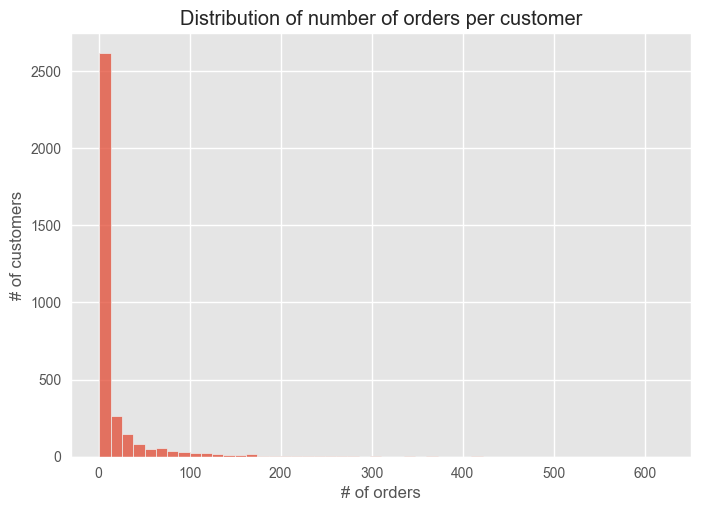

In [502]:
ax = sns.histplot(n_basket, bins=50)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers')
plt.show()

### Cohort Analysis

In [503]:
df_cohort = df.copy()
df_cohort = df_cohort[['CUST_CODE', 'BASKET_ID', 'SHOP_MONTH']].drop_duplicates()

df_cohort['cohort'] = df_cohort.groupby('CUST_CODE')['SHOP_MONTH'].transform('min')

df_cohort = df_cohort.groupby(['cohort', 'SHOP_MONTH']).agg(n_customers=('CUST_CODE', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.SHOP_MONTH - df_cohort.cohort).apply(attrgetter('n'))

cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

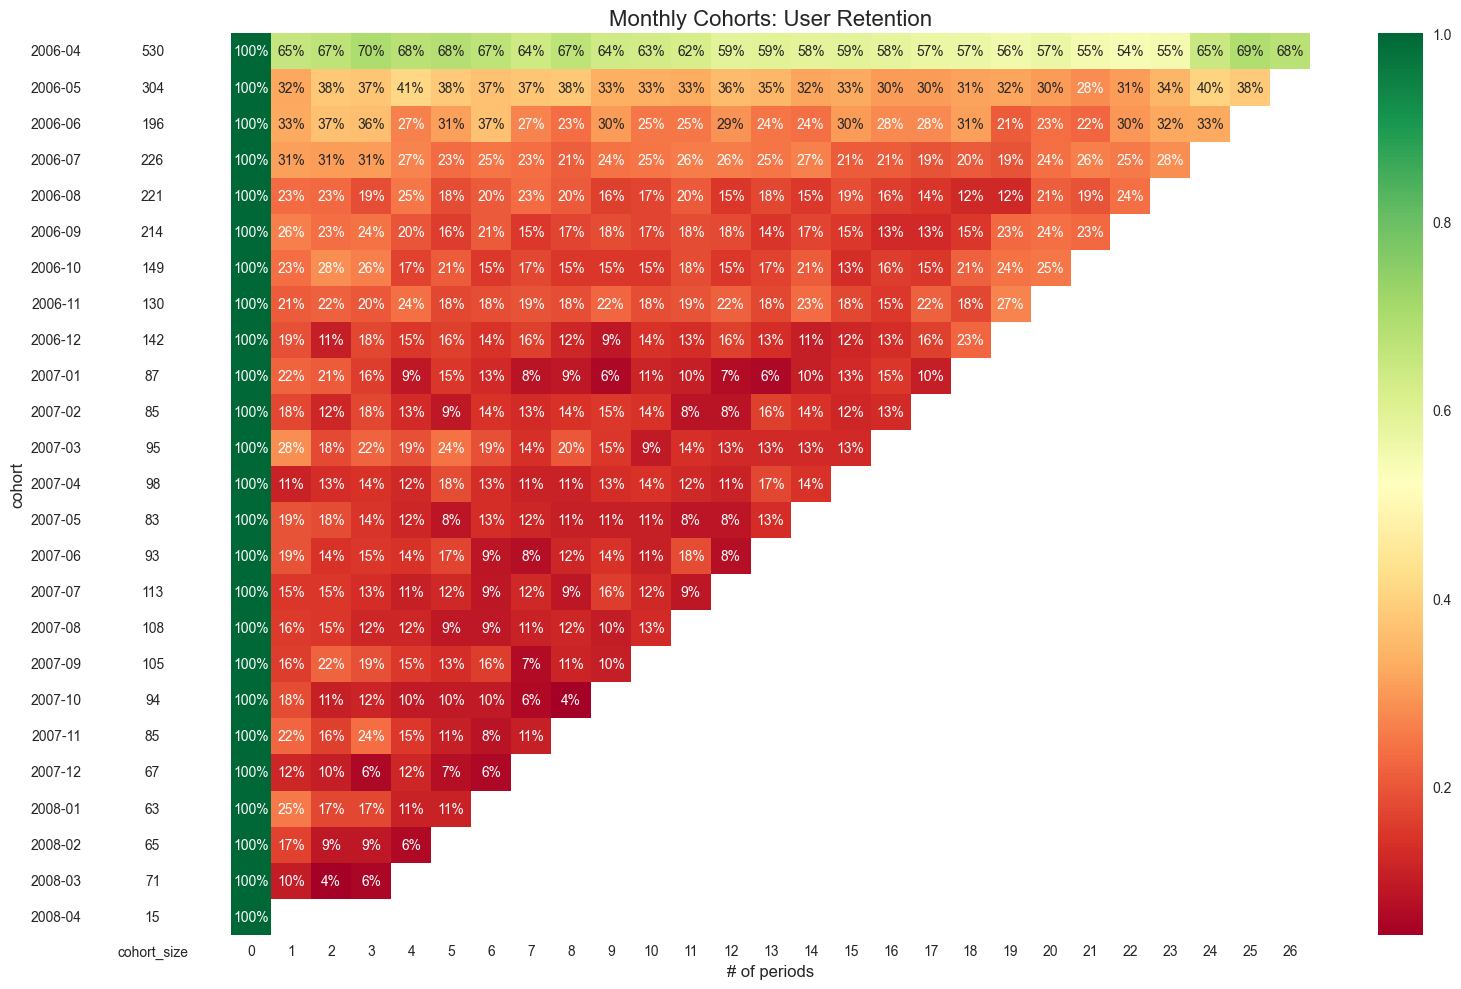

In [504]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 10), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

### churn plot

In [505]:
df_churn = df.copy()
df_churn = df_churn[['CUST_CODE', 'SHOP_MONTH']].drop_duplicates().sort_values(by='SHOP_MONTH').reset_index(drop=True)
df_churn['start_month'] = df_churn.groupby('CUST_CODE')['SHOP_MONTH'].transform('min')
df_churn['period_number'] = (df_churn['SHOP_MONTH'] - df_churn['start_month']).apply(attrgetter('n')).astype(int)

df_churn.tail(3)

,CUST_CODE,SHOP_MONTH,start_month,period_number
22149,CUST0000550874,2008-06,2006-04,26
22150,CUST0000529999,2008-06,2007-08,10
22151,CUST0000915221,2008-06,2006-08,22


In [506]:
# set status labels

df_churn['labels'] = df_churn.apply(lambda row: 'new' if row['SHOP_MONTH'] == row['start_month'] else '', axis=1)
maxmonth = df_churn['SHOP_MONTH'].max()

for cust_code in df_churn['CUST_CODE'].unique() :
    period = df_churn.loc[df_churn['CUST_CODE'] == cust_code, :]['period_number']
    n = 0
    
    for p in period:
        if n+1==p : 
            df_churn.loc[(df_churn['CUST_CODE'] == cust_code) & (df_churn['period_number'] == p), ['labels']] = df_churn.loc[(df_churn['CUST_CODE'] == cust_code) & (df_churn['period_number'] == p), ['labels']].replace('','repeat')
            n+=1

        elif n+1 < p :
            last_order = df_churn.loc[(df_churn['CUST_CODE'] == cust_code) & (df_churn['period_number'] == n)]
            new_row = pd.DataFrame({'CUST_CODE': cust_code, 'labels': 'churn', 'period_number':n+1, 'SHOP_MONTH':last_order['SHOP_MONTH'].values[0]+1}, index=[0])
            df_churn = pd.concat([new_row,df_churn.loc[:]])

            df_churn.loc[(df_churn['CUST_CODE'] == cust_code) & (df_churn['period_number'] == p), ['labels']] = df_churn.loc[(df_churn['CUST_CODE'] == cust_code) & (df_churn['period_number'] == p), ['labels']].replace('','reactivate')
            n=p
            
    user_maxmonth = df_churn[df_churn['CUST_CODE'] == cust_code]['SHOP_MONTH'].max()
    if user_maxmonth != maxmonth:
        new_row = pd.DataFrame({'CUST_CODE': cust_code, 'labels': 'churn', 'period_number':p+1, 'SHOP_MONTH':user_maxmonth+1}, index=[0])
        df_churn = pd.concat([new_row,df_churn.loc[:]])

df_churn.tail(3)

,CUST_CODE,labels,period_number,SHOP_MONTH,start_month
22149,CUST0000550874,repeat,26,2008-06,2006-04
22150,CUST0000529999,reactivate,10,2008-06,2007-08
22151,CUST0000915221,repeat,22,2008-06,2006-08


In [507]:
df_churn_plot = pd.pivot_table(data=df_churn, values='CUST_CODE', index='SHOP_MONTH', columns='labels', aggfunc='count', fill_value=0).reset_index()
df_churn_plot['churn'] = -df_churn_plot['churn']
df_churn_plot['SHOP_MONTH'] = df_churn_plot['SHOP_MONTH'].astype('str')

df_churn_plot.tail(3)

labels,SHOP_MONTH,churn,new,reactivate,repeat
24,2008-04,-324,15,386,504
25,2008-05,-357,0,385,548
26,2008-06,-363,0,370,570


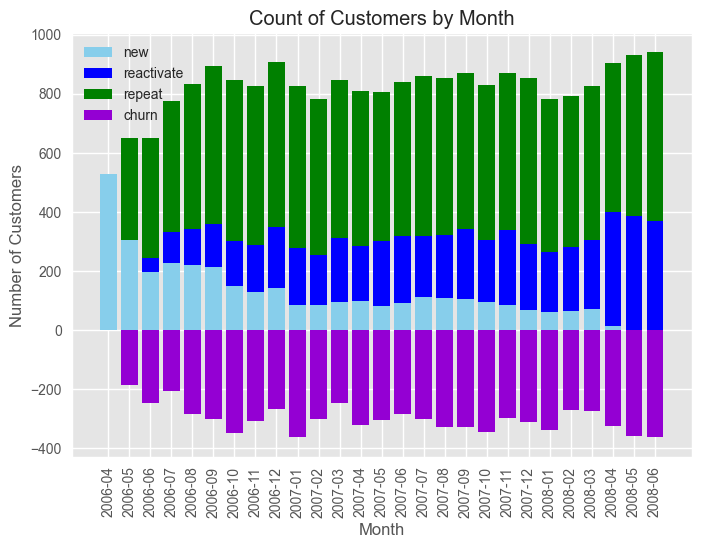

In [510]:
ax = plt.gca()
bottoms = 0 

labels = ['new', 'reactivate', 'repeat']
c = ['skyblue', 'blue', 'green']
for i in range(len(labels)):
  plt.bar( x = df_churn_plot['SHOP_MONTH'],
           height=df_churn_plot[labels[i]],
           color = c[i],
           bottom=bottoms,
           label=labels[i])

  bottoms += df_churn_plot[labels[i]].fillna(0)

ax.bar(height=df_churn_plot['churn'], 
       x=df_churn_plot['SHOP_MONTH'], 
       color='darkviolet', 
       bottom=0,
       label='churn')

plt.xticks(rotation='vertical')

plt.legend(loc='upper left')
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.title('Count of Customers by Month')

plt.show()